In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

GC_CONTENT_WINDOW_SIZE = 1000000

## Compute SNV scores of a set of positive and negative enhancers linked to genes that are known to be under negative selection or no selection, respectively


In [2]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" 
    f" -b <(tail -n +2 {b_filename})"
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)
  b_file_header = get_header(b_filename)

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_scores_numeric(df): 
  # we don't want to include enhancers that don't overlap any Chen windows
  df = df[df['chen_chrom'] != '.'] 

  # having removed records where 'chen_score' is '.', we can now convert the column to a float
  # having removed records where 'corrected_chen_score' is '.', we can now convert the column to a float
  # having removed records where 'filtered_chen_score' is '.', we can now convert the column to a float
  # having removed records where 'window_GC_content' is '.', we can now convert the column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'chen_score': float,
      'corrected_chen_score': float,
      'filtered_chen_score': float,
      'window_GC_content': float,
    }
  )

  return df 
  
def assign_scores_to_labeled_enhancers():
  chen_data_directory = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
  a_filename = f'{chen_data_directory}/Supplementary_Data_6_ESM.bed' # labeled enhancers
  b_filename = f'{chen_data_directory}/Supplementary_Data_2.GC_content_{GC_CONTENT_WINDOW_SIZE}.corrected.bed' # scores for 1kb windows
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/labeled-enhancers-intersect-chen-windows.GC_content_{GC_CONTENT_WINDOW_SIZE}.corrected.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['enhancer_chen_overlap'],
  )

  df = df[
    (df['enhancer_chrom'] != 'chrX') &
    (df['enhancer_chrom'] != 'chrY')
  ]

  df = make_scores_numeric(df)
  
  # though unlikely, some enhancers may intersect multiple Chen windows, 
  # so let's group by enhancer, and aggregare scores over all Chen windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'chen_score': [np.max],
      'corrected_chen_score': [np.max],
      'filtered_chen_score': [np.max],
      'window_GC_content': [np.mean]
    }
  )

  df = df.drop(columns=[
    'enhancer_Gnocchi',
    'LOEUF underpowered'
  ])

  constrained_labels = ['Haploinsufficient', 'MGI essential',	'OMIM dominant', 'LOEUF constrained']
  constrained_enhancers = df[df[constrained_labels].any(axis=1)]

  unconstrained_labels = ['Olfactory', 'LOEUF unconstrained']
  unconstrained_enhancers = df[df[unconstrained_labels].any(axis=1)]
  
  ambiguous_enhancers = pd.merge(constrained_enhancers, unconstrained_enhancers, how='inner')

  constrained_enhancers = pd.merge(constrained_enhancers, ambiguous_enhancers, how='outer', indicator=True)
  constrained_enhancers = constrained_enhancers[constrained_enhancers['_merge'] == 'left_only']
  constrained_enhancers = constrained_enhancers.drop(columns=['_merge'])
  constrained_enhancers['truly constrained'] = True

  unconstrained_enhancers = pd.merge(unconstrained_enhancers, ambiguous_enhancers, how='outer', indicator=True)
  unconstrained_enhancers = unconstrained_enhancers[unconstrained_enhancers['_merge'] == 'left_only']
  unconstrained_enhancers = unconstrained_enhancers.drop(columns=['_merge'])
  unconstrained_enhancers['truly constrained'] = False

  df = pd.concat([constrained_enhancers, unconstrained_enhancers])
  df = df.reset_index(drop=True)

  return df 

pd.set_option('display.max_columns', 100)

LABELED_EXAMPLES = assign_scores_to_labeled_enhancers()
LABELED_EXAMPLES

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/labeled-enhancers-intersect-chen-windows.GC_content_1000000.corrected.bed
<ipython-input-2-2cbc03fcf1cd>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer,Haploinsufficient,MGI essential,OMIM dominant,LOEUF constrained,Olfactory,LOEUF unconstrained,max chen_score,max corrected_chen_score,max filtered_chen_score,mean window_GC_content,truly constrained
0,chr1,1003620,1003820,AGRN,chr1-1003620-1003820,False,True,False,False,False,False,5.938154,1.939605,2.979417,0.517996,True
1,chr1,1347020,1347420,DVL1,chr1-1347020-1347420,False,False,True,False,False,False,-0.604302,-2.327393,1.860996,0.576041,True
2,chr1,1536220,1537020,TMEM240,chr1-1536220-1537020,False,False,True,False,False,False,5.401829,1.029468,3.238727,0.570806,True
3,chr1,1554620,1555020,ATAD3A,chr1-1554620-1555020,False,False,True,False,False,False,4.059724,0.304463,1.584306,0.569781,True
4,chr1,2128961,2129161,GABRD,chr1-2128961-2129161,False,True,True,True,False,False,3.499737,0.045254,3.531299,0.565593,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,chr9,122807921,122808921,OR1K1,chr9-122807921-122808921,False,False,False,False,True,False,1.049799,0.530994,1.290332,0.407189,False
4228,chr9,122807921,122808921,OR1L6,chr9-122807921-122808921,False,False,False,False,True,False,1.049799,0.530994,1.290332,0.407189,False
4229,chr9,122807921,122808921,OR5C1,chr9-122807921-122808921,False,False,False,False,True,False,1.049799,0.530994,1.290332,0.407189,False
4230,chr9,134922954,134923154,FCN1,chr9-134922954-134923154,False,False,False,False,False,True,1.528600,-0.706740,1.196153,0.536773,False


## Plot the distribution of scores of positive and negative enhancers

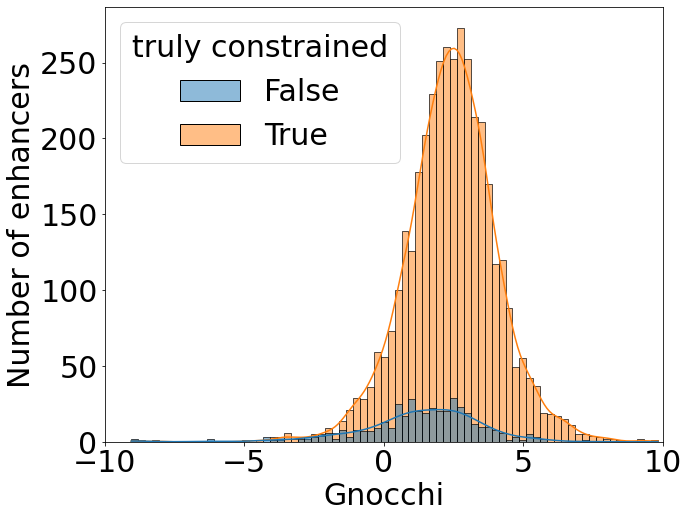

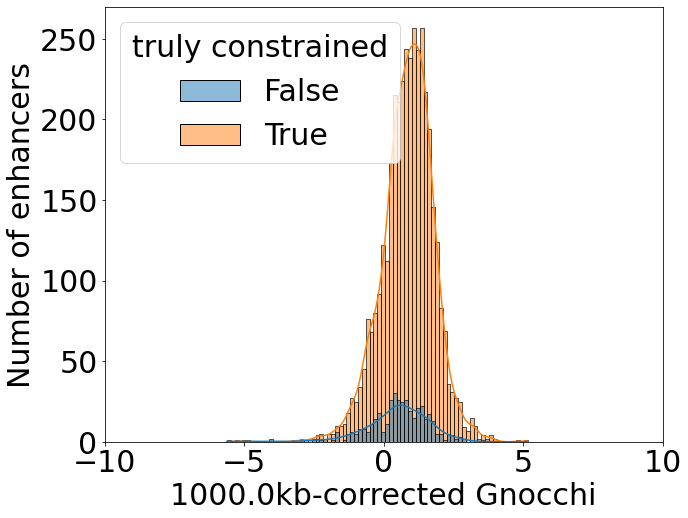

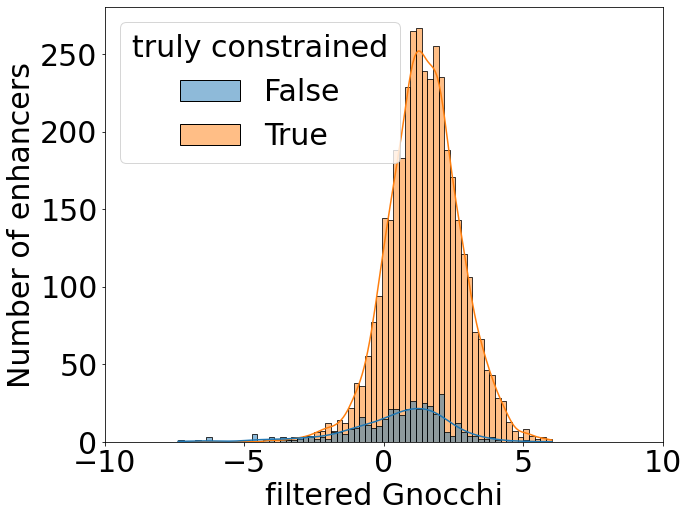

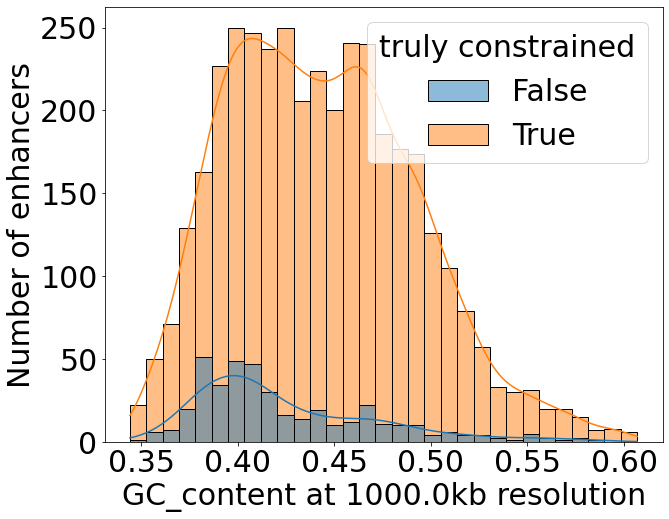

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (10, 8)

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='max chen_score', hue='truly constrained', kde=True)
plt.xlabel('Gnocchi')
plt.ylabel('Number of enhancers')
plt.xlim(-10, 10)
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='max corrected_chen_score', hue='truly constrained', kde=True)
plt.xlabel(f'{GC_CONTENT_WINDOW_SIZE/1e3}kb-corrected Gnocchi')
plt.ylabel('Number of enhancers')
plt.xlim(-10, 10)
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='max filtered_chen_score', hue='truly constrained', kde=True)
plt.xlabel(f'filtered Gnocchi')
plt.ylabel('Number of enhancers')
plt.xlim(-10, 10)
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='mean window_GC_content', hue='truly constrained', kde=True)
plt.xlabel(f'GC_content at {GC_CONTENT_WINDOW_SIZE/1e3}kb resolution')
plt.ylabel('Number of enhancers')
plt.show()

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

def predict_constraint(df, features, prob_threshold): 
  X = df[features]
  y = df['truly constrained']

  # model = LinearDiscriminantAnalysis()
  # model = QuadraticDiscriminantAnalysis()
  model = LogisticRegression() 

  model.fit(X, y)

  df['predicted to be constrained'] = model.predict_proba(X)[:, 1] > prob_threshold

  return df 

# original-gnocchi classifier 
predict_constraint(
  LABELED_EXAMPLES, 
  features=['max chen_score'], 
  prob_threshold=0.7
)

,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer,Haploinsufficient,MGI essential,OMIM dominant,LOEUF constrained,Olfactory,LOEUF unconstrained,max chen_score,max corrected_chen_score,max filtered_chen_score,mean window_GC_content,truly constrained,predicted to be constrained
0,chr1,1003620,1003820,AGRN,chr1-1003620-1003820,False,True,False,False,False,False,5.938154,1.939605,2.979417,0.517996,True,True
1,chr1,1347020,1347420,DVL1,chr1-1347020-1347420,False,False,True,False,False,False,-0.604302,-2.327393,1.860996,0.576041,True,True
2,chr1,1536220,1537020,TMEM240,chr1-1536220-1537020,False,False,True,False,False,False,5.401829,1.029468,3.238727,0.570806,True,True
3,chr1,1554620,1555020,ATAD3A,chr1-1554620-1555020,False,False,True,False,False,False,4.059724,0.304463,1.584306,0.569781,True,True
4,chr1,2128961,2129161,GABRD,chr1-2128961-2129161,False,True,True,True,False,False,3.499737,0.045254,3.531299,0.565593,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,chr9,122807921,122808921,OR1K1,chr9-122807921-122808921,False,False,False,False,True,False,1.049799,0.530994,1.290332,0.407189,False,True
4228,chr9,122807921,122808921,OR1L6,chr9-122807921-122808921,False,False,False,False,True,False,1.049799,0.530994,1.290332,0.407189,False,True
4229,chr9,122807921,122808921,OR5C1,chr9-122807921-122808921,False,False,False,False,True,False,1.049799,0.530994,1.290332,0.407189,False,True
4230,chr9,134922954,134923154,FCN1,chr9-134922954-134923154,False,False,False,False,False,True,1.528600,-0.706740,1.196153,0.536773,False,True


In [5]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['truly constrained']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp) # type: ignore
  recall = tp / (tp + fn) # type: ignore

  return precision, recall

def predict_and_compute_precision_recall(df, features, prob_threshold, log=False): 
  if log: print(prob_threshold)
  df = predict_constraint(df, features, prob_threshold)
  precision, recall = compute_precision_recall(df, log)
  return precision, recall
  
predict_and_compute_precision_recall(
  LABELED_EXAMPLES, 
  features=['max chen_score'], 
  prob_threshold=0.7
)

(0.9089823220258003, 0.9932132602453667)

In [6]:
def plot_precision_recall(df, features, prob_thresholds, color, linestyle, log=False): 
  precision_recall = [
    predict_and_compute_precision_recall(df, features, prob_threshold, log=log)
    for prob_threshold in prob_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label=f'using {features}', color=color, linestyle=linestyle, marker='o', markersize=5)

## Naive classifier 

In [7]:
def predict_and_compute_precision_recall_under_naive_classifier(df, score, score_threshold):
  df['predicted to be constrained'] = df[score] > score_threshold
  TP = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == True)].shape[0]
  FP = df[(df['truly constrained'] == False) & (df['predicted to be constrained'] == True)].shape[0]
  FN = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == False)].shape[0]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  return precision, recall

In [8]:
def plot_precision_recall_under_naive_classifier(df, score, score_thresholds, color, linestyle): 
  precision_recall = [
    predict_and_compute_precision_recall_under_naive_classifier(
      df, 
      score, 
      score_threshold
    )
    for score_threshold in score_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(
    recalls, 
    precisions, 
    label=f'naive classifier (thresholding "{score}")', 
    color=color,
    linestyle=linestyle,
    marker='o',
    markersize=5
  )

## Baseline classifier

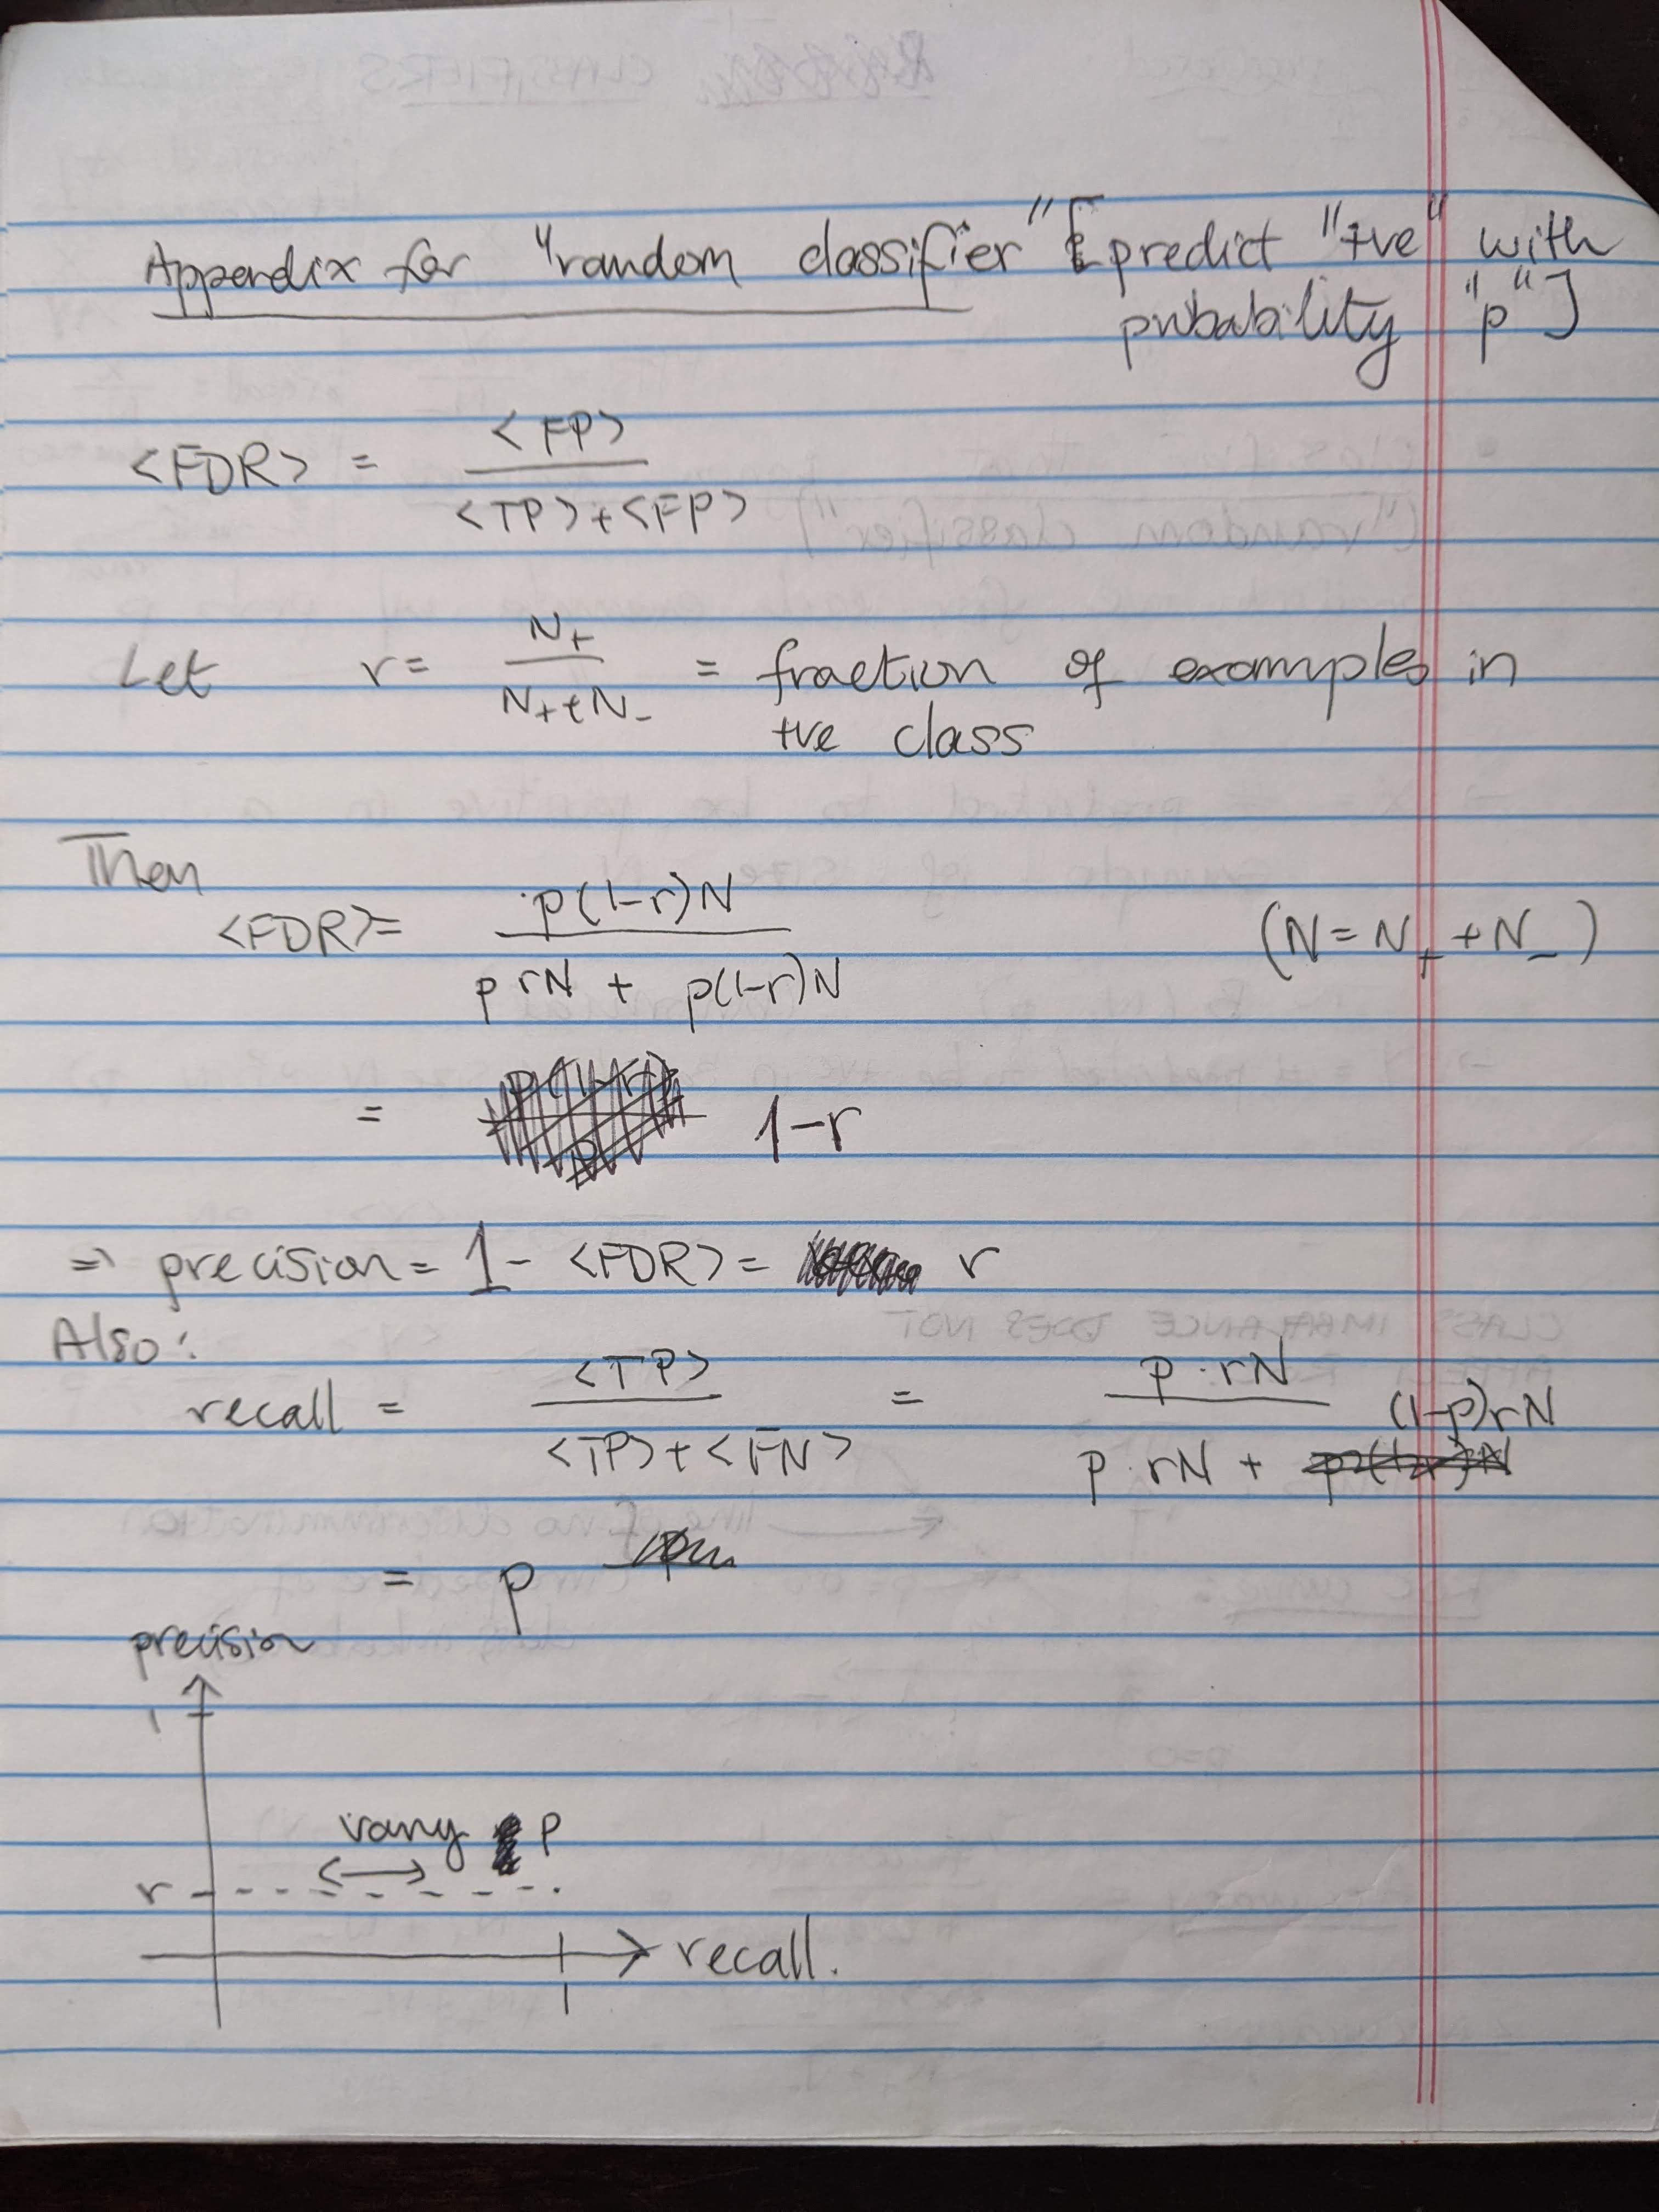

In [9]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## Compare all classifiers in one PR plot

In [10]:
def compute_positive_fraction(df):
  # this is "r" in the baseline-classifier theory 
  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  return number_positive_examples / (number_negative_examples + number_positive_examples)

compute_positive_fraction(LABELED_EXAMPLES)

0.9052457466918714

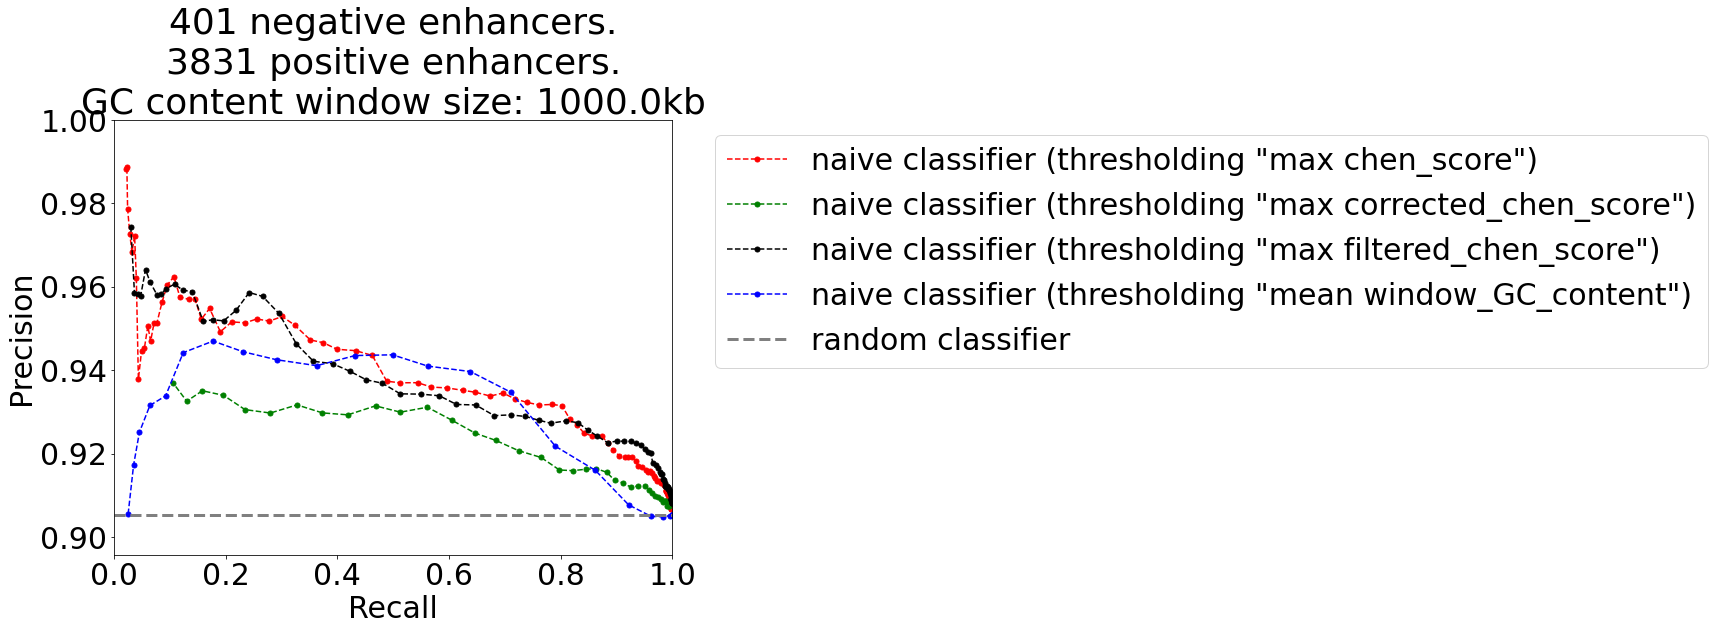

In [11]:
def plot_precision_recall_for_all_classifiers(df): 
  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='max chen_score',
    score_thresholds=np.arange(-4, 6, 0.1),
    color='red',
    linestyle='--'
  )  
  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='max corrected_chen_score',
    score_thresholds=np.arange(-2, 2, 0.1),
    color='green',
    linestyle='--'
  )
  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='max filtered_chen_score',
    score_thresholds=np.arange(-4, 4, 0.1),
    color='black',
    linestyle='--'
  )
  plot_precision_recall_under_naive_classifier(
    LABELED_EXAMPLES, 
    score='mean window_GC_content',
    score_thresholds=np.arange(0.30, 0.55, 0.01),
    color='blue',
    linestyle='--',
  )

  # random classifier
  r = compute_positive_fraction(df)
  plt.plot([0, 1], [r, r], linestyle='--', linewidth=3, color='grey', label='random classifier')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xlim(0, 1)
  plt.ylim(r - (1-r)*0.1, 1)

  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  plt.title(
    f'{number_negative_examples} negative enhancers.\n'
    f'{number_positive_examples} positive enhancers.\n'
    f'GC content window size: {GC_CONTENT_WINDOW_SIZE/1e3}kb'
  )
  
plot_precision_recall_for_all_classifiers(LABELED_EXAMPLES)

## TODO 

Does regressing out GC bias makes the model more specific in the noncoding genome (at the expense of being less specific in the coding genome)? 
* pleiotropic enhancers: experiments/germline-model/chen-et-al-2022/deletion-pileup-around-filtered-enhancers.ipynb
* pathogenic clinvar variants: experiments/germline-model/chen-et-al-2022/pathogenic_variant_enrichment.ipynb
